<a href="https://colab.research.google.com/github/daryjores/portfolio/blob/main/thesis_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Acquisition and Preprocessing with GEE API

the following code Get Bi-annual NDVI images from GEE 2019-2023

In [ ]:
# Install and import necessary libraries
import ee
import folium
import json

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-daryjores')

# Function to add Earth Engine layer to folium map
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add Earth Engine layer method to folium
folium.Map.add_ee_layer = add_ee_layer

def export_ndvi_to_drive(ndvi_image, description, folder, roi, scale=10):
    """Export an NDVI image to Google Drive."""
    task = ee.batch.Export.image.toDrive(
        image=ndvi_image,
        description=description,
        folder=folder,
        scale=scale,
        region=roi.getInfo()['coordinates'],
        maxPixels=1e13
    )
    task.start()


# Function to calculate NDVI from Sentinel-2 data
def get_ndvi_image(start_date, end_date, roi):
    collection = ee.ImageCollection('COPERNICUS/S2') \
        .filterDate(start_date, end_date) \
        .filterBounds(roi) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))  # Adjust as needed

    def add_ndvi(image):
        ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')  # B8 is NIR, B4 is Red
        return image.addBands(ndvi)

    ndvi_collection = collection.map(add_ndvi)
    ndvi_composite = ndvi_collection.qualityMosaic('NDVI')
    return ndvi_composite.select('NDVI')

# Load the GeoJSON file
with open('/content/drive/MyDrive/EE_dataset/stdyarea.geojson', 'r') as file:
    geojson = json.load(file)

# Extract the polygon coordinates from the GeoJSON
polygon_coords = geojson['features'][0]['geometry']['coordinates']

# Create an ee.Geometry.Polygon object
roi = ee.Geometry.Polygon(polygon_coords)
print("ROI:", roi.getInfo())

# Define the Google Drive folder where images will be saved
drive_folder = 'S2DATA'  # Make sure this folder exists in your Google Drive

# Define visualization parameters for NDVI
ndvi_params = {'min': 0, 'max': 1, 'palette': ['blue', 'white', 'green']}

# Loop through each year and period to visualize and export NDVI
for year in range(2019, 2024):
    for period in ['01-01', '07-01']:
        end_date = '06-30' if period == '01-01' else '12-31'
        start_date = f'{year}-{period}'
        end_date = f'{year}-{end_date}'

        # Generate a description for the export based on the date range
        description = f'NDVI_{year}_{period.replace("-", "")}_to_{end_date.replace("-", "")}'

        # Get the NDVI image
        ndvi_image = get_ndvi_image(start_date, end_date, roi)

        # Export the NDVI image to Google Drive
        export_ndvi_to_drive(ndvi_image, description, drive_folder, roi)

        # Create a folium map and add the NDVI layer
        map = folium.Map(location=[-1.22, 37.08], zoom_start=10)
        map.add_ee_layer(ndvi_image, ndvi_params, f'NDVI {start_date} to {end_date}')

        # Display the map
        display(map)


The following code check the images downloaded. You can keep running it over each images downloaded for each sensor data

In [ ]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# Path to your downloaded NDVI image
image_path = '/content/drive/MyDrive/GFCMasks/Mask_2021.tif'

# Open the image
with rasterio.open(image_path) as src:
    # Display image metadata
    print(f'Width: {src.width}, Height: {src.height}')
    print(f'Number of bands: {src.count}')
    print(f'Coordinate Reference System (CRS): {src.crs}')
    print(f'Bounds: {src.bounds}')
    print(f'Band datatypes: {[src.dtypes for i in src.indexes]}')
    print(f'Band descriptions: {[src.descriptions[i - 1] for i in src.indexes]}')

    # Read the first band into an array and visualize it
    ndvi_band = src.read(1)  # Assuming NDVI is the first band

    plt.figure(figsize=(10, 10))
    show(ndvi_band, transform=src.transform, cmap='RdYlGn')
    plt.title('NDVI Image Visualization')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')


The Folllowing code download perfectly Deforestation mask from the Global Forest Mask for the year 2019,2020,2021,2022 and 2023

In [ ]:
import ee
import json

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-daryjores')

def export_gfc_deforestation_mask(year, roi, drive_folder):
    """Export a binary deforestation mask for a specific year using the GFC dataset."""
    gfc_dataset = ee.Image("UMD/hansen/global_forest_change_2023_v1_11")

    # Create a mask indicating areas of deforestation for the specified year
    deforestation_mask = gfc_dataset.expression(
        "(loss == 1) && (lossYear == year_since_2000)",
        {
            'loss': gfc_dataset.select('loss'),
            'lossYear': gfc_dataset.select('lossyear'),
            'year_since_2000': year - 2000  # Calculate the lossYear value for the specified year
        }
    )

    description = f'Mask_{year}'

    task = ee.batch.Export.image.toDrive(
        image=deforestation_mask.selfMask(),  # Apply mask to visualize loss in original locations
        description=description,
        folder=drive_folder,
        scale=30,  # GFC's native resolution
        region=roi.getInfo()['coordinates'],
        maxPixels=1e13
    )
    task.start()
    print(f'Exporting {description} to {drive_folder}...')

# Load the GeoJSON file
with open('/content/drive/MyDrive/EE_dataset/stdyarea.geojson', 'r') as file:
    geojson = json.load(file)

# Extract the polygon coordinates from the GeoJSON
polygon_coords = geojson['features'][0]['geometry']['coordinates']

# Create an ee.Geometry.Polygon object
roi = ee.Geometry.Polygon(polygon_coords)

# Define the Google Drive folder where images will be saved
drive_folder = 'GFCMasks'

# Loop to export deforestation masks for 2019 through 2023
for year in range(2019, 2024):  # Note: 2024 data will not be available in the 2023 dataset
    export_gfc_deforestation_mask(year, roi, drive_folder)


The following code supposed to download Sentinel 1 images

In [ ]:
import ee
import folium
import json

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-daryjores')

def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

def export_s1_to_drive(start_date, end_date, roi, polarization, drive_folder):
    """Export Sentinel-1 SAR imagery to Google Drive."""
    # Filter Sentinel-1 images by date, ROI, and polarization (VH for vegetation/land changes)
    s1_collection = ee.ImageCollection('COPERNICUS/S1_GRD')\
                     .filterDate(start_date, end_date)\
                     .filterBounds(roi)\
                     .filter(ee.Filter.eq('instrumentMode', 'IW'))\
                     .filter(ee.Filter.listContains('transmitterReceiverPolarisation', polarization))\
                     .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))  # Use descending pass for consistency

    # Composite the images using the median reducer to minimize noise
    s1_composite = s1_collection.median()

    description = f'Sentinel-1_{polarization}_{start_date.replace("-", "")}_to_{end_date.replace("-", "")}'

    task = ee.batch.Export.image.toDrive(
        image=s1_composite,
        description=description,
        folder=drive_folder,
        scale=10,
        region=roi.getInfo()['coordinates'],
        maxPixels=1e13
    )
    task.start()
    print(f'Exporting {description} to {drive_folder}...')

# Load the GeoJSON file
with open('/content/drive/MyDrive/EE_dataset/stdyarea.geojson', 'r') as file:
    geojson = json.load(file)

# Extract the polygon coordinates from the GeoJSON
polygon_coords = geojson['features'][0]['geometry']['coordinates']

# Create an ee.Geometry.Polygon object
roi = ee.Geometry.Polygon(polygon_coords)
print("ROI:", roi.getInfo())

# Define the Google Drive folder where images will be saved
drive_folder = 'S1DATA'  # Make sure this folder exists in your Google Drive

# Define the polarization to use for deforestation mapping
polarization = 'VH'

# Loop through the desired years and periods to process and export Sentinel-1 data
for year in range(2019, 2024):  # Adjust the range as necessary
    for period in ['01-01', '07-01']:
        end_date = '06-30' if period == '01-01' else '12-31'
        start_date = f'{year}-{period}'
        end_date = f'{year}-{end_date}'

        description = f'Sentinel-1_{polarization}_{year}_{period.replace("-", "")}_to_{end_date.replace("-", "")}'

        export_s1_to_drive(start_date, end_date, roi, polarization, drive_folder)


ROI: {'type': 'Polygon', 'coordinates': [[[18.61650606804514, -3.3782952555976467], [18.721200232870498, -3.378295231110799], [18.82589436642818, -3.378295224373256], [18.930588485779055, -3.3782951972799293], [19.035282610417035, -3.378295257518766], [19.035282610417035, -3.1830356125335175], [18.930588485779055, -3.1830356213516326], [18.82589436642818, -3.183035648138369], [18.721200232870498, -3.1830356564301856], [18.61650606804514, -3.1830356822333776], [18.61650606804514, -3.3782952555976467]]]}
Exporting Sentinel-1_VH_20190101_to_20190630 to S1DATA...
Exporting Sentinel-1_VH_20190701_to_20191231 to S1DATA...
Exporting Sentinel-1_VH_20200101_to_20200630 to S1DATA...
Exporting Sentinel-1_VH_20200701_to_20201231 to S1DATA...
Exporting Sentinel-1_VH_20210101_to_20210630 to S1DATA...
Exporting Sentinel-1_VH_20210701_to_20211231 to S1DATA...
Exporting Sentinel-1_VH_20220101_to_20220630 to S1DATA...
Exporting Sentinel-1_VH_20220701_to_20221231 to S1DATA...
Exporting Sentinel-1_VH_2023

In [ ]:
Code to visuale our study area within the congo basin

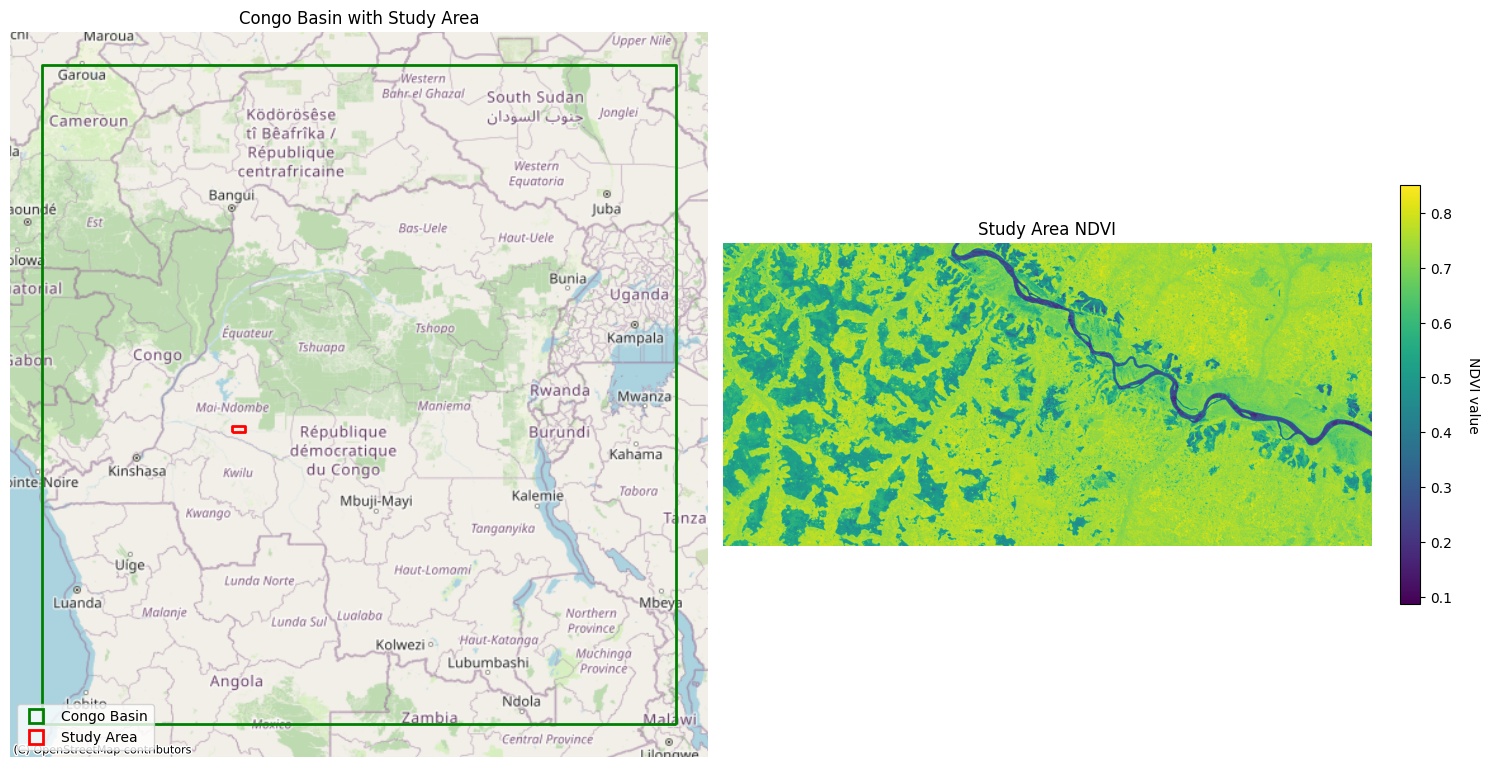

In [ ]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from shapely.geometry import box
from rasterio.plot import show, plotting_extent
import rasterio

# Load your study area GeoJSON
study_area_gdf = gpd.read_file('/content/drive/MyDrive/EE_dataset/stdyarea.geojson').to_crs(epsg=4326)

# Define the broader region (e.g., Congo Basin) as a GeoDataFrame using the box method
minx, miny, maxx, maxy = 12, -13.4, 34, 9.3  # Congo Basin coordinates
congo_basin_gdf = gpd.GeoDataFrame(geometry=[box(minx, miny, maxx, maxy)], crs="EPSG:4326")

# Ensure both GeoDataFrames are in WGS 84 CRS
study_area_gdf = study_area_gdf.to_crs(epsg=3857)
congo_basin_gdf = congo_basin_gdf.to_crs(epsg=3857)

# Load the NDVI image
with rasterio.open('/content/drive/MyDrive/S2DATA/NDVI_2019_0101_to_20190630.tif') as src:  # Update this path to your NDVI image
    ndvi = src.read(1)
    extent = plotting_extent(src)

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 10))  # Adjust as needed

# Plot the broader Congo Basin region with a basemap on the left
congo_basin_gdf.plot(ax=ax[0], facecolor='none', edgecolor='green', linewidth=2)
study_area_gdf.plot(ax=ax[0], facecolor='none', edgecolor='red', linewidth=2)
ctx.add_basemap(ax[0], source=ctx.providers.OpenStreetMap.Mapnik)
ax[0].set_title('Congo Basin with Study Area')
ax[0].set_axis_off()

# Create custom legend handles
congo_basin_patch = plt.Line2D([0], [0], linestyle="none", marker="s", markersize=10,
                               markerfacecolor='none', markeredgewidth=2, markeredgecolor='green', label='Congo Basin')
study_area_patch = plt.Line2D([0], [0], linestyle="none", marker="s", markersize=10,
                               markerfacecolor='none', markeredgewidth=2, markeredgecolor='red', label='Study Area')
ax[0].legend(handles=[congo_basin_patch, study_area_patch], loc='lower left')

# Plot the NDVI image on the right
ndvi_im = ax[1].imshow(ndvi, extent=extent, cmap='viridis')
ax[1].set_title('Study Area NDVI')
ax[1].set_axis_off()

# Add colorbar for NDVI
cbar = fig.colorbar(ndvi_im, ax=ax[1], fraction=0.03, pad=0.04)
cbar.set_label('NDVI value', rotation=270, labelpad=20)

# Adjust plots to tightly fit in the figure area
plt.tight_layout()
plt.show()


# DATA PREPARATION

First Make sure you can access your data easily

In [ ]:
# Define the base path for the dataset directories
base_path = '/content/drive/MyDrive/thesis_lab/'  # Update this path to the location of your dataset folders in Google Drive

# Define paths to the specific directories
s1_data_path = f'{base_path}S1DATA/'
s2_data_path = f'{base_path}S2DATA/'
gfc_masks_path = f'{base_path}GFCMasks/'


In [ ]:
import os

# List first few files in each directory to verify access
print("S1 Data Samples:", os.listdir(s1_data_path)[:5])
print("S2 Data Samples:", os.listdir(s2_data_path)[:5])
print("GFC Masks Samples:", os.listdir(gfc_masks_path)[:5])


S1 Data Samples: ['s1_2019_01.tif', 's1_2019_02.tif', 's1_2020_01.tif', 's1_2021_02.tif', 's1_2022_01.tif']
S2 Data Samples: ['s2_2019_01.tif', 's2_2019_02.tif', 's2_2020_01.tif', 's2_2020_02.tif', 's2_2021_01.tif']
GFC Masks Samples: ['Mask_2022.tif', 'Mask_2023.tif', 'Mask_2020.tif', 'Mask_2019.tif', 'Mask_2021.tif']


In [ ]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 42.5 MB/s eta 0:00:00


In [ ]:
import rasterio

def print_image_info(image_path):
    with rasterio.open(image_path) as src:
        print(f"File: {image_path}")
        print(f"Dimensions: {src.width} x {src.height}")
        print(f"Number of Bands: {src.count}")
        print(f"Coordinate Reference System (CRS): {src.crs}")
        print(f"Transform: {src.transform}\n")

# Replace '/path/to/your/image.tif' with the actual path to your Sentinel-1 or Sentinel-2 image, or your deforestation mask
print_image_info('/content/drive/MyDrive/thesis_lab/GFCMasks/Mask_2019.tif')


File: /content/drive/MyDrive/thesis_lab/GFCMasks/Mask_2019.tif
Dimensions: 1555 x 725
Number of Bands: 1
Coordinate Reference System (CRS): EPSG:4326
Transform: | 0.00, 0.00, 18.62|
| 0.00,-0.00,-3.18|
| 0.00, 0.00, 1.00|



In [ ]:
import rasterio
from rasterio.enums import Resampling
import numpy as np
import os

# Set the target dimensions to match your Sentinel images
target_width = 4663
target_height = 2175

# Directory containing the original masks
masks_dir = '/content/drive/MyDrive/thesis_lab/GFCMasks/'

# Directory to save the resampled masks
resampled_masks_dir = '/content/drive/MyDrive/thesis_lab/ResampledGFCMasks/'

# Create the output directory if it doesn't exist
if not os.path.exists(resampled_masks_dir):
    os.makedirs(resampled_masks_dir)

# List all mask files
mask_files = [f for f in os.listdir(masks_dir) if f.endswith('.tif')]

# Iterate through each mask file and resample
for mask_file in mask_files:
    with rasterio.open(os.path.join(masks_dir, mask_file)) as src:
        # Define the new transform and dimensions based on the target dimensions
        transform = src.transform * src.transform.scale(
            (src.width / target_width),
            (src.height / target_height)
        )
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': src.crs,
            'transform': transform,
            'width': target_width,
            'height': target_height
        })

        # Read the mask data and resample
        data = src.read(
            out_shape=(src.count, target_height, target_width),
            resampling=Resampling.nearest
        )

        # Save the resampled mask to a new file
        resampled_mask_path = os.path.join(resampled_masks_dir, mask_file)
        with rasterio.open(resampled_mask_path, 'w', **kwargs) as dst:
            dst.write(data)

    print(f'Resampled {mask_file} and saved to {resampled_mask_path}')


Resampled Mask_2022.tif and saved to /content/drive/MyDrive/thesis_lab/ResampledGFCMasks/Mask_2022.tif
Resampled Mask_2023.tif and saved to /content/drive/MyDrive/thesis_lab/ResampledGFCMasks/Mask_2023.tif
Resampled Mask_2020.tif and saved to /content/drive/MyDrive/thesis_lab/ResampledGFCMasks/Mask_2020.tif
Resampled Mask_2019.tif and saved to /content/drive/MyDrive/thesis_lab/ResampledGFCMasks/Mask_2019.tif
Resampled Mask_2021.tif and saved to /content/drive/MyDrive/thesis_lab/ResampledGFCMasks/Mask_2021.tif


In [ ]:
import rasterio
import numpy as np
import os

def normalize_and_save(image_path, output_path):
    with rasterio.open(image_path) as src:
        img = src.read(out_dtype=np.float32)
        normalized_img = img / 255.0  # Normalizing the pixel values

        profile = src.profile
        profile.update(dtype=rasterio.float32)

        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(normalized_img)

def process_directory(input_dir, output_dir):
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        if filename.endswith('.tif'):
            image_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)
            normalize_and_save(image_path, output_path)
            print(f"Normalized and saved: {filename}")

# Define paths
base_drive_path = '/content/drive/MyDrive/thesis_lab/'  # Adjust this base path
s1_data_dir = os.path.join(base_drive_path, 'S1DATA')
s2_data_dir = os.path.join(base_drive_path, 'S2DATA')
s1_normalized_dir = os.path.join(base_drive_path, 'S1DATA_Normalized')
s2_normalized_dir = os.path.join(base_drive_path, 'S2DATA_Normalized')

# Process Sentinel-1 and Sentinel-2 directories
process_directory(s1_data_dir, s1_normalized_dir)
process_directory(s2_data_dir, s2_normalized_dir)


Normalized and saved: s1_2019_01.tif
Normalized and saved: s1_2019_02.tif
Normalized and saved: s1_2020_01.tif
Normalized and saved: s1_2021_02.tif
Normalized and saved: s1_2022_01.tif
Normalized and saved: s1_2022_02.tif
Normalized and saved: s1_2023_01.tif
Normalized and saved: s1_2023_02.tif
Normalized and saved: s1_2020_02.tif
Normalized and saved: s1_2021_01.tif
Normalized and saved: s2_2019_01.tif
Normalized and saved: s2_2019_02.tif
Normalized and saved: s2_2020_01.tif
Normalized and saved: s2_2020_02.tif
Normalized and saved: s2_2021_01.tif
Normalized and saved: s2_2021_02.tif
Normalized and saved: s2_2022_01.tif
Normalized and saved: s2_2022_02.tif
Normalized and saved: s2_2023_01.tif
Normalized and saved: s2_2023_02.tif


Patching the data

In [ ]:
import glob
import os

# Define directories
base_dir = '/content/drive/MyDrive/thesis_lab/'
s1_patches_dir = os.path.join(base_dir, 'S1_Patches')
s2_patches_dir = os.path.join(base_dir, 'S2_Patches')
mask_patches_dir = os.path.join(base_dir, 'Mask_Patches')

# Get lists of patch files
s1_patch_files = glob.glob(os.path.join(s1_patches_dir, '*.tif'))
s2_patch_files = glob.glob(os.path.join(s2_patches_dir, '*.tif'))
mask_patch_files = glob.glob(os.path.join(mask_patches_dir, '*.tif'))

# Count the number of patches in each dataset
num_s1_patches = len(s1_patch_files)
num_s2_patches = len(s2_patch_files)
num_mask_patches = len(mask_patch_files)

# Print the counts
print(f"Number of Sentinel-1 patches: {num_s1_patches}")
print(f"Number of Sentinel-2 patches: {num_s2_patches}")
print(f"Number of Mask patches: {num_mask_patches}")

# Verify that all counts are equal
if num_s1_patches == num_s2_patches == num_mask_patches:
    print("All datasets have the same number of patches. Ready for splitting.")
else:
    print("Dataset patch counts do not match. Please check the datasets for inconsistencies.")


Number of Sentinel-1 patches: 1590
Number of Sentinel-2 patches: 1590
Number of Mask patches: 1590
All datasets have the same number of patches. Ready for splitting.


In [ ]:
import rasterio
from rasterio.windows import Window
import numpy as np
import os
import glob

def create_patches_for_dataset(s1_dir, s2_dir, mask_dir, output_dir_base, tile_size=256):
    """
    Create patches from Sentinel-1, Sentinel-2, and mask datasets,
    discarding patches based on the mask 'nodata' condition.

    Args:
    - s1_dir: Directory for Sentinel-1 images.
    - s2_dir: Directory for Sentinel-2 images.
    - mask_dir: Directory for mask images.
    - output_dir_base: Base output directory to save patches for all datasets.
    - tile_size: The size of the square patches.
    """
    # Create output directories
    s1_output_dir = os.path.join(output_dir_base, 'S1_Patches')
    s2_output_dir = os.path.join(output_dir_base, 'S2_Patches')
    mask_output_dir = os.path.join(output_dir_base, 'Mask_Patches')
    for dir_path in [s1_output_dir, s2_output_dir, mask_output_dir]:
        os.makedirs(dir_path, exist_ok=True)

    # List and sort image files from each directory
    s1_images = sorted(glob.glob(os.path.join(s1_dir, '*.tif')))
    s2_images = sorted(glob.glob(os.path.join(s2_dir, '*.tif')))
    mask_images = sorted(glob.glob(os.path.join(mask_dir, '*.tif')))

    for s1_image_path, s2_image_path, mask_image_path in zip(s1_images, s2_images, mask_images):
        # Extract base filename to use in patch filenames
        base_name = os.path.splitext(os.path.basename(s1_image_path))[0]

        # Open the mask image to check for 'nodata' areas
        with rasterio.open(mask_image_path) as mask_src:
            mask_meta = mask_src.meta.copy()

            for i in range(0, mask_src.width, tile_size):
                for j in range(0, mask_src.height, tile_size):
                    window = Window(i, j, tile_size, tile_size)
                    mask_patch = mask_src.read(window=window)

                    # Check if the mask patch is entirely 'nodata'
                    if not np.any(mask_patch):
                        continue  # Skip patches with 'nodata'

                    # If mask patch is valid, process corresponding Sentinel patches
                    for image_path, output_dir in [(s1_image_path, s1_output_dir), (s2_image_path, s2_output_dir)]:
                        with rasterio.open(image_path) as src:
                            img_patch = src.read(window=window)
                            out_meta = src.meta.copy()
                            out_meta.update({"height": tile_size, "width": tile_size, "transform": rasterio.windows.transform(window, src.transform)})

                            patch_filename = f'{base_name}_P{i//tile_size}_{j//tile_size}.tif'
                            patch_output_path = os.path.join(output_dir, patch_filename)

                            with rasterio.open(patch_output_path, 'w', **out_meta) as dest:
                                dest.write(img_patch)

                    # Save the mask patch
                    mask_patch_filename = f'{base_name}_P{i//tile_size}_{j//tile_size}.tif'
                    mask_patch_output_path = os.path.join(mask_output_dir, mask_patch_filename)
                    with rasterio.open(mask_patch_output_path, 'w', **mask_meta) as mask_dest:
                        mask_dest.write(mask_patch)

# Example usage:
base_dir = '/content/drive/MyDrive/thesis_lab/'
create_patches_for_dataset(s1_dir=os.path.join(base_dir, 'S1DATA_Normalized'),
                           s2_dir=os.path.join(base_dir, 'S2DATA_Normalized'),
                           mask_dir=os.path.join(base_dir, 'ResampledGFCMasks'),
                           output_dir_base=base_dir,
                           tile_size=256)


#  Experimentation 1
Unet with SAR Data (s1)
Unet with optical data (s2)

In [46]:
from tensorflow.keras import backend as K

def precision(y_true, y_pred):
    """Precision metric."""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """Recall metric."""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_score(y_true, y_pred):
    """F1 score metric."""
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

def dice_coef(y_true, y_pred, smooth=1):
    """Dice coefficient metric."""
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou(y_true, y_pred):
    """Intersection over union (IoU) metric."""
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=[1,2,3])
    jac = (intersection + K.epsilon()) / (sum_ - intersection + K.epsilon())
    return K.mean(jac)


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def get_unet(input_img, n_filters=64, dropout=0.1, batchnorm=True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)

    # Expansive Path
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

input_img = Input((256, 256, 1), name='img')
model = get_unet(input_img, n_filters=64, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy",
              metrics=["accuracy", precision, recall, f1_score, dice_coef, iou])


model.summary()  # Uncomment to see the model summary


Loading SAR DATA

In [65]:
import tensorflow as tf
import glob
import os

# Define base directory
base_dir = "/content/drive/MyDrive/thesis_lab/"

# Define directories for SAR patches and Mask patches
sar_patches_dir = os.path.join(base_dir, "S1_Patches")
mask_patches_dir = os.path.join(base_dir, "Mask_Patches")

# List all SAR and Mask patch files
sar_patch_files = sorted(glob.glob(os.path.join(sar_patches_dir, "*.tif")))
mask_patch_files = sorted(glob.glob(os.path.join(mask_patches_dir, "*.tif")))


In [66]:
from sklearn.model_selection import train_test_split

# Assuming the lists of files are aligned
dataset = list(zip(sar_patch_files, mask_patch_files))

# Split the dataset into training (60%), validation (20%), and test (20%)
train_val, test = train_test_split(dataset, test_size=0.2, random_state=42)
train, val = train_test_split(train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2


In [67]:
import tensorflow as tf

# Assuming 'train', 'val', and 'test' are lists of tuples with your preprocessed SAR and Mask paths
# Example format of 'train': [('/path/to/sar1.tif', '/path/to/mask1.tif'), ...]

# Unzipping file paths
train_sar_paths, train_mask_paths = zip(*train)
val_sar_paths, val_mask_paths = zip(*val)
test_sar_paths, test_mask_paths = zip(*test)


In [68]:
# Convert lists into TensorFlow string tensors
train_sar_paths_tf = tf.constant(train_sar_paths)
train_mask_paths_tf = tf.constant(train_mask_paths)
val_sar_paths_tf = tf.constant(val_sar_paths)
val_mask_paths_tf = tf.constant(val_mask_paths)
test_sar_paths_tf = tf.constant(test_sar_paths)
test_mask_paths_tf = tf.constant(test_mask_paths)

# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_sar_paths_tf, train_mask_paths_tf))
val_ds = tf.data.Dataset.from_tensor_slices((val_sar_paths_tf, val_mask_paths_tf))
test_ds = tf.data.Dataset.from_tensor_slices((test_sar_paths_tf, test_mask_paths_tf))


In [70]:
import tensorflow as tf
import numpy as np
import imageio.v2 as imageio

def process_path(sar_path, mask_path):
    # Decode SAR image
    sar_img = imageio.imread(sar_path.numpy().decode('utf-8'))
    mask_img = imageio.imread(mask_path.numpy().decode('utf-8'))

    # Convert images to float32 tensors
    sar_img = tf.convert_to_tensor(sar_img, dtype=tf.float32)
    mask_img = tf.convert_to_tensor(mask_img, dtype=tf.float32)

    # Add a new axis to match shape [256, 256, 1]
    sar_img = tf.expand_dims(sar_img, axis=-1)
    mask_img = tf.expand_dims(mask_img, axis=-1)

    return sar_img, mask_img

def tf_process_path(sar_path, mask_path):
    [sar_img, mask_img] = tf.py_function(process_path, [sar_path, mask_path], [tf.float32, tf.float32])
    sar_img.set_shape([256, 256, 1])
    mask_img.set_shape([256, 256, 1])
    return sar_img, mask_img

# Apply the tf_process_path function with adjustments
train_ds = train_ds.map(tf_process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(tf_process_path, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(tf_process_path, num_parallel_calls=tf.data.AUTOTUNE)


In [71]:
# Apply the process_path function
#train_ds = train_ds.map(lambda x, y: process_path(x, y), num_parallel_calls=tf.data.AUTOTUNE)
#val_ds = val_ds.map(lambda x, y: process_path(x, y), num_parallel_calls=tf.data.AUTOTUNE)
#test_ds = test_ds.map(lambda x, y: process_path(x, y), num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle, batch, and prefetch
train_ds = train_ds.shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_cb = ModelCheckpoint("best_model.h5", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(train_ds,
                    epochs=50,
                    validation_data=val_ds,
                    callbacks=[checkpoint_cb, early_stopping_cb])


Epoch 1/50
